In [1]:
import pickle
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from datasets import load_metric

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizerFast
from transformers import Trainer, TrainingArguments

In [2]:
BATCH_SIZE = 32
EVAL_PART_SIZE = 0.04
MODELS_PATH = './models/'
DATASETS_PATH = '../input/contradictory-my-dear-watson/'
CUR_MODEL_NAME = 'xlm-roberta-base'

In [3]:
def init_random_seed(value=42):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
init_random_seed()

# Data Explore

In [4]:
train_eval_df = pd.read_csv(DATASETS_PATH + 'train.csv')
test_df = pd.read_csv(DATASETS_PATH + 'test.csv')

In [5]:
train_eval_df

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


## Explore train/test intersection

In [6]:
train_eval_df.loc[train_eval_df.premise.isin(test_df.premise)]

,id,premise,hypothesis,lang_abv,language,label
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
5,ed7d6a1e62,"Bir çiftlikte birisinin, ağıla kapatılmış bu ö...",Çiftlikte insanlar farklı terimler kullanırlar.,tr,Turkish,0
7,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2
8,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1
13,4c25aa4c06,我希望你的领主能够最终开始认识到，向这样的人授予国王委员会的愚蠢行为反对我的所有建议。,大人刚刚接受了我的意见，并且采取了相应的行动。,zh,Chinese,2
...,...,...,...,...,...,...
12109,f23a80f42c,Ca'daan felt his skin get hot and unable to co...,Ca'daan was getting sunburned.,en,English,1
12110,ed9d9e8ec2,"Well, we've just got to get down to it, that's...",We should take a break from this.,en,English,2
12113,3fb793c27f,The center had become a hodgepodge of unconnec...,The programs at the center were not connected ...,en,English,0
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [7]:
train_eval_df.loc[train_eval_df.hypothesis.isin(test_df.hypothesis)]

,id,premise,hypothesis,lang_abv,language,label


## Explore label/language distribution

In [8]:
lang_agg = train_eval_df.groupby('language').count()

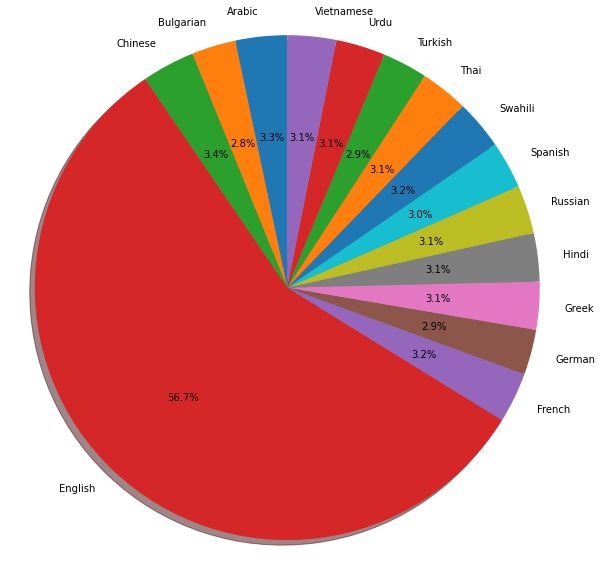

In [9]:
labels = lang_agg.iloc[:, 0].index
sizes = lang_agg.iloc[:, 0]


fig1, ax1 = plt.subplots(figsize=(10, 10))

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

In [10]:
lang_stats_list = []
lang_stats_list.append((train_eval_df.groupby('label')['id'].count()/train_eval_df.shape[0]).rename('general'))
for lang in train_eval_df.lang_abv.unique():
    lang_ser = train_eval_df.loc[train_eval_df.lang_abv == lang].groupby('label')['id'].count()/train_eval_df.loc[train_eval_df.lang_abv == lang].shape[0]
    lang_ser = lang_ser.rename(lang)
    lang_stats_list.append(lang_ser)

In [11]:
# Label proportion per language
pd.concat(lang_stats_list, axis=1)

,general,en,fr,th,tr,ur,ru,bg,de,ar,zh,hi,sw,vi,es,el
label,,,,,,,,,,,,,,,,
0,0.344554,0.353275,0.341026,0.326146,0.313390,0.349081,0.351064,0.359649,0.307692,0.309227,0.340633,0.334225,0.363636,0.32190,0.322404,0.322581
1,0.320132,0.315284,0.330769,0.339623,0.324786,0.288714,0.329787,0.324561,0.330484,0.321696,0.355231,0.299465,0.283117,0.39314,0.306011,0.341398
2,0.335314,0.331441,0.328205,0.334232,0.361823,0.362205,0.319149,0.315789,0.361823,0.369077,0.304136,0.366310,0.353247,0.28496,0.371585,0.336022


In [12]:
train_eval_df.loc[train_eval_df[['premise', 'hypothesis', 'label']].duplicated()]

,id,premise,hypothesis,lang_abv,language,label


In [13]:
train_eval_df.premise.str.len().describe()

count    12120.000000
mean       107.373185
std         71.089954
min          4.000000
25%         55.000000
50%         96.000000
75%        146.000000
max        967.000000
Name: premise, dtype: float64

In [14]:
train_eval_df.hypothesis.str.len().describe()

count    12120.000000
mean        53.892327
std         25.302358
min          4.000000
25%         36.000000
50%         51.000000
75%         67.000000
max        276.000000
Name: hypothesis, dtype: float64

In [15]:
print('Overall number of unique premises:', train_eval_df.premise.nunique())
print('Number of premises occure more than once:', train_eval_df.loc[train_eval_df.premise.isin(train_eval_df.loc[train_eval_df[['premise']].duplicated()].premise)].shape[0])

Overall number of unique premises: 8209
Number of premises occure more than once: 6711


In [16]:
train_eval_df.groupby('premise')['hypothesis'].count().describe()

count    8209.000000
mean        1.476428
std         0.721239
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: hypothesis, dtype: float64

### Quick thoughts
* Label distibution is balanced along all languages: So **accuracy** metric remains representative.
* Dataset is quite small: So **overfitting** is to be expected, which will mostly affect prediction of '1' label.
* Wondering should train and eval datasets share some premises.

# Data splitting
* **Hypothesis**: If all dulpicated premises will be placed in the same sample selection the better generalization will be achieved.
* **So**: train/eval data split will share no premises.
* **Problem** is that test dataset unlike eval dataset shares more then half of premises with train dataset so eval data will lose more of its representativeness.

In [17]:
# Create an index for each unique premise
prem_id_series = pd.Series(train_eval_df.premise.unique()).reset_index(name='premise')
train_eval_df = train_eval_df.merge(prem_id_series, how='left', on='premise').rename(columns={'index': 'premise_idx'})
train_eval_df

,id,premise,hypothesis,lang_abv,language,label,premise_idx
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,1
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0,2
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,3
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1,4
...,...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2,4432
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0,553
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2,7233
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2,8208


In [18]:
N_UNIQUE_PREMISES = train_eval_df.premise_idx.max()
TRAIN_PREMISES_NUMB = int((1 - EVAL_PART_SIZE) * N_UNIQUE_PREMISES)

In [19]:
premise_idxes_list = [i for i in range(N_UNIQUE_PREMISES)]
init_random_seed()
random.shuffle(premise_idxes_list)

In [20]:
train_premise_idxes = premise_idxes_list[:TRAIN_PREMISES_NUMB]

In [21]:
train_df =  train_eval_df.loc[train_eval_df.premise_idx.isin(train_premise_idxes)]
eval_df =  train_eval_df.loc[~train_eval_df.premise_idx.isin(train_premise_idxes)]
assert train_df.shape[0] + eval_df.shape[0] == train_eval_df.shape[0]
print('Train dataset size:', train_df.shape[0])
print('Eval dataset size:', eval_df.shape[0])
print('Test dataset size:', test_df.shape[0])

Train dataset size: 11642
Eval dataset size: 478
Test dataset size: 5195


# Data Preprocess

 A RoBERTa sequence has the following format:

<p>single sequence: &lt;s> X &lt;/s></p>
<p>pair of sequences: &lt;s> A &lt;/s>&lt;/s> B &lt;/s></p>

In [22]:
tokenizer = XLMRobertaTokenizerFast.from_pretrained(CUR_MODEL_NAME)

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [23]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [24]:
print('Vocab size:', tokenizer.vocab_size)

Vocab size: 250002


In [25]:
BOS_TOKEN_ID = tokenizer.bos_token_id
EOS_TOKEN_ID = tokenizer.eos_token_id
PAD_TOKEN_ID = tokenizer.pad_token_id

In [26]:
train_features_encoded = tokenizer(train_df[['premise', 'hypothesis']].values.tolist()).input_ids
train_labels = train_df.label.values.tolist()

eval_features_encoded = tokenizer(eval_df[['premise', 'hypothesis']].values.tolist()).input_ids
eval_labels = eval_df.label.values.tolist()

In [27]:
print('Max seq len in train/eval selections:', max(len(doc) for doc in train_features_encoded), max(len(doc) for doc in eval_features_encoded))

Max seq len in train/eval selections: 246 118


In [28]:
class SeqClassDataset(Dataset):
    def __init__(self, features, targets=None) -> None:
        super().__init__()
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        
        features = torch.LongTensor(self.features[idx])
        if self.targets is not None:
            target = torch.LongTensor([self.targets[idx]])
            return features, target
        else:
            target = None
            return features, target


In [29]:
train_dataset = SeqClassDataset(train_features_encoded, train_labels)
eval_dataset = SeqClassDataset(eval_features_encoded, eval_labels)

In [30]:
def custom_collate(data):
    features, labels = zip(*data)
    features = torch.nn.utils.rnn.pad_sequence(features, batch_first=True, padding_value=PAD_TOKEN_ID)
    attn_mask = (features != PAD_TOKEN_ID).int()
    labels = torch.cat(labels) if labels[0] is not None else None
    return {'input_ids': features, 'attention_mask': attn_mask, 'labels': labels} 

In [31]:
init_random_seed()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate, shuffle=False)

In [32]:
next(iter(train_dataloader))

{'input_ids': tensor([[     0,  20271,     70,  ...,      1,      1,      1],
         [     0,  14547,   8258,  ...,      1,      1,      1],
         [     0, 146825,  20019,  ...,      1,      1,      1],
         ...,
         [     0,   2654,   3754,  ...,      1,      1,      1],
         [     0,  63982,  46826,  ...,      1,      1,      1],
         [     0,   1087,  25872,  ...,      1,      1,      1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'labels': tensor([0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 2, 0, 0, 1, 2, 0, 1, 0, 1, 0, 2, 1, 0, 1,
         2, 0, 2, 0, 1, 2, 2, 0])}

# Model loading

In [33]:
!sudo apt-get install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 93 not upgraded.
Need to get 3316 kB of archives.
After this operation, 11.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 git-lfs amd64 2.9.2-1 [3316 kB]
Fetched 3316 kB in 1s (2212 kB/s)  
Selecting previously unselected package git-lfs.
(Reading database ... 108827 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.9.2-1_amd64.deb ...
Unpacking git-lfs (2.9.2-1) ...
Setting up git-lfs (2.9.2-1) ...
Processing triggers for man-db (2.9.1-1) ...
Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


In [34]:
from huggingface_hub import notebook_login

notebook_login()

In [35]:
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [36]:
wandb.init(project="XLMRobertaBase NLI CMDW", entity="remeris")

wandb: Currently logged in as: remeris. Use `wandb login --relogin` to force relogin


In [37]:
model = XLMRobertaForSequenceClassification.from_pretrained(CUR_MODEL_NAME, num_labels=len(set(train_labels)))

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

# Train/Eval stage

In [38]:
glue_metric = load_metric('glue', 'mnli')

In [39]:
def compute_metrics(data):
    logits, labels = data
    output = glue_metric.compute(predictions=logits.argmax(1).tolist(), references=labels.squeeze().tolist())  
    return output

In [40]:
training_args = TrainingArguments(
    output_dir=MODELS_PATH,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    do_train=True,
    do_eval=True,
    
    # Setting arguments for early-stopping-ish
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    logging_strategy='epoch',
    
    # Couldn't find hyperparameters for XLM-R, so they were taken from the original RoBERTa paper
    learning_rate=1e-5,
    weight_decay=0.1,
    warmup_ratio=0.06,
    num_train_epochs=10,
    save_total_limit=1,
    
    push_to_hub=True,
    hub_model_id='Remeris/XLMRobertaBase_NLI_CMDW',
    hub_strategy='end'
)

In [41]:
trainer = Trainer(
    tokenizer=tokenizer,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=custom_collate
)

Cloning https://huggingface.co/Remeris/XLMRobertaBase_NLI_CMDW into local empty directory.


In [42]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 11642
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3640
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy
1,1.101500,1.094386,0.357741
2,0.928300,0.771179,0.669456
3,0.717200,0.723242,0.702929
4,0.596800,0.734557,0.702929
5,0.511900,0.796041,0.717573
6,0.423700,0.834416,0.730126
7,0.367900,0.821830,0.723849
8,0.327000,0.862846,0.725941
9,0.297000,0.899617,0.717573
10,0.267000,0.909130,0.717573


***** Running Evaluation *****
  Num examples = 478
  Batch size = 32
Saving model checkpoint to ./models/checkpoint-364
Configuration saved in ./models/checkpoint-364/config.json
Model weights saved in ./models/checkpoint-364/pytorch_model.bin
tokenizer config file saved in ./models/checkpoint-364/tokenizer_config.json
Special tokens file saved in ./models/checkpoint-364/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 478
  Batch size = 32
Saving model checkpoint to ./models/checkpoint-728
Configuration saved in ./models/checkpoint-728/config.json
Model weights saved in ./models/checkpoint-728/pytorch_model.bin
tokenizer config file saved in ./models/checkpoint-728/tokenizer_config.json
Special tokens file saved in ./models/checkpoint-728/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 478
  Batch size = 32
Saving model checkpoint to ./models/checkpoint-1092
Configuration saved in ./models/checkpoint-1092/config.json
Model weights saved 

TrainOutput(global_step=3640, training_loss=0.5538384322281722, metrics={'train_runtime': 1386.6696, 'train_samples_per_second': 83.957, 'train_steps_per_second': 2.625, 'total_flos': 5738568391215324.0, 'train_loss': 0.5538384322281722, 'epoch': 10.0})

In [43]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 478
  Batch size = 32


{'eval_loss': 0.8344155550003052,
 'eval_accuracy': 0.7301255230125523,
 'eval_runtime': 1.4645,
 'eval_samples_per_second': 326.39,
 'eval_steps_per_second': 10.242,
 'epoch': 10.0}

In [44]:
trainer.push_to_hub()

Saving model checkpoint to ./models/
Configuration saved in ./models/config.json
Model weights saved in ./models/pytorch_model.bin
tokenizer config file saved in ./models/tokenizer_config.json
Special tokens file saved in ./models/special_tokens_map.json
Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 32.0k/1.04G [00:00<?, ?B/s]

Upload file runs/Nov18_22-11-27_ee63e630726d/events.out.tfevents.1668810891.ee63e630726d.24.2: 100%|##########…

Upload file sentencepiece.bpe.model:   1%|          | 32.0k/4.83M [00:00<?, ?B/s]

Upload file runs/Nov18_22-11-27_ee63e630726d/1668809503.378406/events.out.tfevents.1668809503.ee63e630726d.24.…

Upload file training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

Upload file runs/Nov18_22-11-27_ee63e630726d/events.out.tfevents.1668809503.ee63e630726d.24.0: 100%|##########…

Upload file tokenizer.json:   0%|          | 32.0k/16.3M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Remeris/XLMRobertaBase_NLI_CMDW
   e76192e..ce782b0  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.7301255230125523}]}
To https://huggingface.co/Remeris/XLMRobertaBase_NLI_CMDW
   ce782b0..3f9ff60  main -> main



'https://huggingface.co/Remeris/XLMRobertaBase_NLI_CMDW/commit/ce782b0572993f6aa774ca40c2c448a39fd9fd32'

In [45]:
predicted_labels = []
for batch_idx, batch in enumerate(eval_dataloader):
    for key in batch:
        batch[key] = batch[key].to(model.device)
    out_logits = model(**batch)[1]
    predicted_labels += out_logits.argmax(1).int().tolist()
eval_df['predicted_labels'] = predicted_labels

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [46]:
print(classification_report(eval_df.label, eval_df.predicted_labels))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       171
           1       0.70      0.66      0.68       147
           2       0.75      0.74      0.74       160

    accuracy                           0.73       478
   macro avg       0.73      0.73      0.73       478
weighted avg       0.73      0.73      0.73       478



In [47]:
lang_report_datasets = []
for lang in eval_df.lang_abv.unique():
    cls_dict = classification_report(eval_df.loc[eval_df.lang_abv == lang, 'label'], eval_df.loc[eval_df.lang_abv == lang, 'predicted_labels'], output_dict=True)
    cls_rep_df = pd.DataFrame(cls_dict).transpose()[:-3]
    cls_rep_df['lang_abv'] = [lang] * 3
    lang_report_datasets.append(cls_rep_df)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
pd.concat(lang_report_datasets)

,precision,recall,f1-score,support,lang_abv
0,0.333333,0.666667,0.444444,3.0,th
1,0.500000,0.333333,0.400000,6.0,th
2,0.500000,0.333333,0.400000,3.0,th
0,0.745098,0.808511,0.775510,94.0,en
1,0.743243,0.662651,0.700637,83.0,en
2,0.738636,0.747126,0.742857,87.0,en
0,0.625000,0.714286,0.666667,7.0,de
1,0.500000,0.666667,0.571429,3.0,de
2,1.000000,0.666667,0.800000,6.0,de
0,0.500000,0.500000,0.500000,2.0,zh


# Test predict and submit

In [49]:
test_df

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian
...,...,...,...,...,...
5190,5f90dd59b0,نیند نے وعدہ کیا کہ موٹل نے سوال میں تحقیق کی.,نیمیتھ کو موٹل کی تفتیش کے لئے معاوضہ دیا جارہ...,ur,Urdu
5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock.,en,English
5192,1f0ea92118,她目前的存在，并考虑到他与沃佛斯顿争执的本质，那是尴尬的。,她在与Wolverstone的打斗结束后才在场的事实被看作是很尴尬的。,zh,Chinese
5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English


In [50]:
test_features_encoded = tokenizer(test_df[['premise', 'hypothesis']].values.tolist()).input_ids
test_dataset = SeqClassDataset(test_features_encoded)
test_dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=custom_collate, shuffle=False)

In [51]:
predicted_labels = []
for batch_idx, batch in enumerate(test_dataloader):
    for key in batch:
        if batch[key] is not None:
            batch[key] = batch[key].to(model.device)
    out_logits = model(**batch)[0]
    predicted_labels += out_logits.argmax(1).int().tolist()
test_df['prediction'] = predicted_labels

In [52]:
test_df[['id', 'prediction']]

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,2
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,0
...,...,...
5190,5f90dd59b0,1
5191,f357a04e86,2
5192,1f0ea92118,0
5193,0407b48afb,0


In [53]:
test_df[['id', 'prediction']].to_csv("submission.csv", index = False)